# **Proyecto Final:** Cálculo de PCA aplicado a compresión de imágenes.

**Carlos Bautista$^*$, Edgar Bazo$^*$, Luz Hernández$^*$ e Ita Santiago$^*$**

$^*$ Alumnos de la materia ANCC

## Introducción
Como se vio en clase de optimización, el cómputo matemático ha ayudado al desarrollo tecnológico e informático con un acelerado crecimiento, lo cual ha incrementado la cantidad de información (datos) a computar. Podemos asumir que este crecimiento es exponencial y la forma en la que se trata hoy, con respecto a hace algunos años, no es la misma, lo cual ha impulsado a la investigación y aplicación de matemáticas para optimizar los problemas que esto ha traído. En este contexto, tenemos muy claro que independientemente del avance tecnológico los recursos computacionales (hardware, software) son finitos y los costos de implementación y mantenimiento pueden ser elevados.

En este proyecto, trabajaremos en el análisis de componentes principales (PCA) para datos de imágenes. PCA es una famosa técnica de reducción de dimensionalidad no supervisada que viene a nuestro rescate cada vez que la maldición de la dimensionalidad nos persigue. Aunado a esto, vamos a calcular las componentes principales haciendo uso del algoritmo de rotaciones de Jacobi para obtener los SVD y a partir de estos los PCA.

Uno de los casos de uso de PCA es que se puede utilizar para la compresión de imágenes, una técnica que minimiza el tamaño en bytes de una imagen manteniendo la mayor calidad de imagen posible. Una imagen de color típica se compone de píxeles, muchos píxeles se unen en una matriz para formar una imagen digital. Dicha imágen digital típica se crea apilando matrices de píxeles rojo, azul y verde de intensidades que van de 0 a 255.

## Teoría

### Repaso de PCA

PCA es uno de los métodos más utilizados para encontrar patrones en los datos y es usado frecuentemente cuando cada observación contiene muchas características y no todas ellas son significativas, pero también se usa cuando existe mucha covarianza entre las características. En pocas palabras, describe los datos resumiéndolos en patrones típicos llamados componentes principales, en donde estos nos permitirán explicar los valores a través de una combinación de ellos.

Las componentes principales encuentran una proyección lineal de datos en un sistema de base ortogonal que tiene la redundancia mínima y conserva la variación en los datos.
Aplicaciones: 
* Identificar la dimensionalidad intrínseca de los datos.
* Representación dimensional más baja de datos con el menor error de reconstrucción.

# Antes de la sección 1.2.2 coloquen el problema de optimización (o problemas de optimización) que se resuelven en el PCA (esto es súper importante)

### PCA para reducción de dimensionalidad

* Si los datos viven en un espacio dimensional inferior, entonces algunos de los valores propios en la matriz se establecen en 0.
* Si queremos reducir la dimensionalidad de los datos de $d$ a algunos fijos $k$ elegimos los eigenvectores correspondientes a los $k$ eigenvalor más altos, i.e. las dimensiones que conservan la mayor parte de la varianza en los datos.
* Esta selección también minimiza el error de reconstrucción de datos (por lo que las mejores $k$ dimensiones conducen al mejor error).

### Algoritmo PCA

Pasos para realizar el PCA: de una matriz $X\in \mathbb{R}_{N\times a}$ a una matriz $X_{pca}\in \mathbb{R}_{N\times b}$:

1. Normalización: Centrar la matriz, substrayendo la media.
2. Calcular la matriz de covarianzas de la matriz centrada $C=\frac{1}{N-1}X^TX$.
3. Calcular los eigenvectores de la matriz de covarianzas.
4. Seleccionar los $m$ eigenvectores correspondientes a los eigenvalores más grandes.

Obtenemos los **Componentes Principales de X** al multiplicar estos eigenvectores por $X_{centrada}^{T}$.

El proceso de PCA identifica aquellas direcciones en las que la varianza es mayor. Como la varianza de una variable se mide en su misma escala elevada al cuadrado, si antes de calcular las componentes no se estandarizan todas las variables para que tengan media 0 y desviación estándar 1, aquellas variables cuya escala sea mayor dominarán al resto. De ahí que sea recomendable estandarizar siempre los datos.

Los pasos anteriores se realizan a la matriz de covarianzas, sin embargo otro enfoque es el cálculo de la descomposición en valores singulares de la matriz X. Tal enfoque tiene ventajas sobre los pasos descritos como es el no calcular la matriz de covarianzas.

### Relación entre de valores singulares y eigenvalores
El número $\sigma$ se denomina valor singular de $A$ si $\sigma=\sqrt{\lambda A^TA}=\sqrt{\lambda AA^T}$ donde: $\lambda A^TA$ y $\lambda AA^T$ es eigenvalor de $A^TA$ y $AA^T$ respectivamente.

### Uso de rotaciones de Jacobi
Este método produce una secuencia de transformaciones ortogonales de la forma $J_k^TAJ_k$ con el objetivo de hacer “más diagonal” a la matriz $A\in\mathbb{R}_{n \times n}$.

Si la matriz $A$ es simétrica y $J_0$ es una transformación de rotación de Jacobi, entonces el esquema iterativo:

$$A_{k+1}=(J_0J_1\dots J_k)^TA(J_0J_1\dots J_k)$$
converge a una matriz diagonal en la que se encuentran los eigenvalores de $A$.

### Algoritmo rotaciones de Jacobi

Dados $A$ simétrica y $tol>0$ definir $A_0=A$, $Q_0=I_n$.

Repetir el siguiente bloque para $k=0,1,2,\dots$

1. Elegir un par de índices $(idx1,idx2)$ según las metodologías vistas en clase,

2. Calcular las entradas $cos(\theta),sin(\theta)$ de la matriz de rotación $J_k$,

3. $A_{k+1}=J^T_kA_kJ_k$,

4. $Q_{k+1}=Q_kJ_k$,

hasta convergencia: satisfacer criterio de paro en el que se utiliza $tol$ y $maxsweeps$.

La matriz $J_k$ se utiliza para eliminar un par de entradas (simétricas) en la matriz $A_k$, esto preserva la simetría de la matriz original. En las columnas de la matriz $Q_k$ se encuentran aproximaciones a los eigenvectores de $A$ y en la diagonal de $A_k$ se tienen aproximaciones a los eigenvalores de $A$.

Una vez analizado todo lo anterior, crearemos las funciones necesarias para llevar a cabo la compresión de imágenes.

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from numpy import cov
from math import sqrt
from scipy.stats import stats
from sklearn.decomposition import PCA

import os, sys
os.chdir("../..")

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [3]:
# función de signo
def sign(x):
    """
    Helper function for computing sign of real number x.
    """
    if x >= 0:
        return 1
    else:
        return -1
    

# función que calcula entradas de matriz de rotación Jacobi
def compute_cos_sin_Jacobi_rotation(Ak, idx1, idx2):
    """
    Helper function for computing entries of Jacobi rotation.
    Args:
        Ak (numpy ndarray): Matrix of iteration k in Jacobi rotation method.
        idx1 (int): index for rows in Jacobi rotation matrix.
        idx2 (int): index for columns in Jacobi rotation matrix.
    Returns:
        c (float): value of cos of theta for Jacobi rotation matrix.
        s (float): value of sin of theta for Jacobi rotation matrix.
    """
    if np.abs(Ak[idx1, idx2]) > np.finfo(float).eps:
        tau = (Ak[idx2, idx2] - Ak[idx1, idx1]) / (2 * Ak[idx1, idx2])
        t_star = sign(tau) / (np.abs(tau) + np.sqrt(1 + tau ** 2))
        c = 1 / np.sqrt(1 + t_star ** 2)
        s = c * t_star
    else:  # no rotation is performed
        c = 1
        s = 0

    return (c, s)


# función que calcula matriz de rotación Jacobi
def compute_Jacobi_rotation(Ak, idx1, idx2):
    """
    Compute Jacobi rotation matrix.
    Args:
        Ak (numpy ndarray): Matrix of iteration k in Jacobi rotation method.
        idx1 (int): index for rows in Jacobi rotation matrix.
        idx2 (int): index for columns in Jacobi rotation matrix.
    Returns:
        J (numpy ndarray): Jacobi rotation matrix.
    """
    c,s = compute_cos_sin_Jacobi_rotation(Ak, idx1, idx2)
    m,n = Ak.shape
    J = np.eye(m)
    J[idx1, idx1] = J[idx2, idx2] = c
    J[idx1, idx2] = s
    J[idx2, idx1] = -s
    return J


def off(A):
    """
        Find the quantity "off(A)" Frobenius norm of 𝐴 without the diagonal..
        Args:
            A (numpy ndarray): Matrix to calculate "off(A)".
        Returns:
            scalar value(float): value of function off(A).
        """
    A_k = A[~np.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], -1)

    return np.linalg.norm(A_k, 'fro')


def max_sweeps(n):
    """
            Find the maximum number of sweeps to iterate in Jacobi's rotation algorithm.
            Args:
                n (int value): It corresponds to the maximum number of entries
            in the matrix that form the upper triangular part of 𝐴 without
            counting the diagonal that are assumed to be different from zero..
            Returns:
                max_sweeps(Int): Maximum number of sweeps.
    """
    max_sw = (n * (n - 1)) / 2

    return max_sw

def jacobi_iteration(a, tol=1.0e-8):
    """
            Jacobi rotations function for symmetric matrices with repeated elimination
            Args:
                a (numpy ndarray): Matrix to compute Jacobi rotation.
                tol (float): a small, positive amount (commonly less than or equal to 10−8).
            Returns:
                a_k (numpy ndarray): vector with eigenvalues of A.
                q_k (numpy ndarray): Matrix with eigenvectors of A.
    """

    # Realizamos una copia de A = A_k
    a_k = a.copy()

    # se define numero de dimension n basado en columnas
    # las entradas totales del triangulo superiores de A
    n = a_k.shape[1]

    # Definimos matriz identidad de x que generara vectores
    q_k = np.identity(n)

    # iniciamos contador de sweeps
    sweeps = 1
    # se calcula el valor maximo de sweeps
    max_sw = max_sweeps(n)

    # se calcula el Off inicial
    off_val = off(a_k)
    # se calcula tolerancia inicial
    tolerancia = tol * np.linalg.norm(a_k, 'fro')

    # se extraen los indices del triangulo sup de x
    tri_sup = np.triu_indices(n, 1)

    # se unen los indices en un solo array para hacer el loop de entradas de rotacion
    index_tri = np.column_stack((tri_sup[0], tri_sup[1]))

    #print("Max_Sweeps {}".format(max_sw))
    #print("------------------------\n\n")

    while off_val > tolerancia and sweeps < max_sw:

        #print("Sweeps {}".format(sweeps))
        #print("------------------------")

        for i in index_tri:
            # print("idx_1 = {}".format(i[0]))
            # print("idx_2 = {}".format(i[1]))

            j = compute_Jacobi_rotation(a_k, i[0], i[1])
            a_k = j.T @ a_k @ j
            q_k = q_k @ j

        # Se calcula nueva off y se imprime
        off_val = off(a_k)
        #print("Off(x_k) = {}".format(off_val))
        # se calcula nueva tolerancia y se imprime
        tolerancia = tol * np.linalg.norm(a_k, 'fro')
        #print("tolerancia = {}\n".format(tolerancia))

        #print("La transformación de x_k queda como:")
        #print(a_k)
        #print("\nLa matriz q_k queda como:")
        #print(q_k)
        #print("------------------------\n\n")

        sweeps += 1
        
        
    # actualizacion del metodo para ordenar los eigenvectores 
    # de forma ascendente de acuerdo a su eigenvalor
    
    # se extraen los valores de la diagonal que en este caso son
    # los eigenvalues
    eValues = np.diag(a_k)
    
    # con esta funcion se extraen los indices
    #  ordenados de forma descendente de los evalues
    sort_eval = eValues.argsort()[::-1]
    
    # se ordenan los eigenvalues de forma descendente
    # y se asigna a_k
    a_k = eValues[sort_eval]

    # utilizando los indices del ordenamiento de los eValues
    # ordenamos la matriz q_k por las columnas y la asignamos de nuevo a q_k
    # con esto se ordena de manera descendente la matriz q_k de acuerdo 
    # a sus evalues a_k
    q_k = q_k[:,sort_eval]
    
    print("Sweeps {}".format(sweeps))
    print("------------------------")
    print("Off(x_k) = {}".format(off_val))
    print("tolerancia = {}\n".format(tolerancia))

    #print("La transformación de x_k queda como:")
    #print(a_k)
    print("\nLa matriz q_k queda como:")
    print(q_k)
    print("------------------------\n\n")

    
    return a_k, q_k



def returnPCA(x, method):
    """
                Return PCA function to calculate the principal components of a matrix
                Args:
                    x (numpy ndarray): Matrix to compute PCA
                    method (str): string that indicates the method to be used for the
                                  approximation of eigenvalues and eigenvectors,
                                  "jacobi" for the jacobi_iteration method or "linalg" for the numpy method
                Returns:
                    x_k (numpy ndarray): vector with eigenvalues of x
                    q_k (numpy ndarray): Matrix with components of x
                    pca (numpy ndarray): Matrix with principal components scores of x
    """

    # se centra x
    x_c = x - x.mean(axis=0)

    # se calcula la covarianza de la matriz centrada transpuesta x_c.T que resulta en v
    v = np.cov(x_c.T)
    # se inicializan las variables a retornar
    x_k = np.empty(x_c.shape)
    q_k = np.empty(x_c.shape)

    # se calculan los eigenvalores y eigen vectores se puede utilizar
    # el metodo de jacobi_iteration o linalg de numpy
    if method == "jacobi":
        x_k, q_k = jacobi_iteration(v, tol=1.0e-8)
    elif method == "linalg":
        x_k, q_k = np.linalg.eig(v)
    else:
        print("no method found")

    # Obtenemos los Scores Componentes Principales de x al multiplicar .dot q_k.T por x_c.T centrada .
    pca = q_k.T.dot(x_c.T)
    # retorna pca.T
    return x_k, q_k, pca.T

Haremos el cálculo de **eigenvalores** y **eigenvectores** de nuestra matriz $X$ de datos utilizando **método de rotaciones de Jacobi y ordenamiento cíclico por renglones.**

Se toman las funciones definidas en la nota [2.3 Algoritmos y aplicaciones de eigenvalores y eigenvectores de una matriz](https://itam-ds.github.io/analisis-numerico-computo-cientifico/2.computo_matricial/2.3/Algoritmos_y_aplicaciones_de_eigenvalores_eigenvectores_de_una_matriz.html) del libro de Optimización.

Definimos las funciones para "diagonalizar" la matriz $X^{T}X$ con rotaciones de Jacobi a través del método de ordenamiento cíclico por renglones.

Primero, definimos funciones auxiliares `off()` y `max_sweeps()` para el criterio de paro

Definimos función que realiza las iteraciones de Jacobi:

Ahora realizaremos el cálculo con una función que implementamos y que nos ayuda a calcular las PCA, basándonos en el método de Jacobi

Recordamos que las "direcciones principales están dadas por las columnas de $V$ (salvo signos positivos o negativos)", y que las "**componentes principales están dadas por la multiplicación matricial de $XV$** (salvo signos positivos o negativos)"

Siguiendo un método más directo y que también funciona, con base en nota [2.4 del libro de Optimización](https://itam-ds.github.io/analisis-numerico-computo-cientifico/2.computo_matricial/2.4/Valores_vectores_singulares_y_algoritmos_para_calcular_la_SVD.html). Podemos obtener PCA multiplicando $X_{centrada}$ por $V$ (obtenida a partir de $Q_k$ resultante de aplicar Jacobi a $X^{T}X$).

## PCA para compresión de imágenes

Como vimos, el análisis de componentes principales, o PCA, es una técnica estadística para convertir datos de alta dimensión en datos de baja dimensión, mediante la selección de las características más importantes que capturan la máxima información (varianza) sobre el conjunto de datos [6]. 

Basamos la idea de nuestras funciones en las características que se seleccionan sobre la base de la varianza que causan en la salida. Como también aprendimos en clase, la característica que causa la mayor variación es el primer componente principal. La característica que es responsable de la segunda varianza más alta se considera el segundo componente principal, y así sucesivamente. Es importante mencionar que los componentes principales no tienen ninguna correlación entre sí.

Aparte de las múltiples aplicaciones de PCA, otra aplicación interesante es la compresión de imágenes, nuestra motivación para usar esta herramienta para eso, se explica en la siguiente sección. 

Echemos un vistazo a cómo podemos lograr esto con Python.

## Motivación

Como se mencionó en la introducción, una de las aplicaciones generales más importantes del PCA es la reducción de dimensionalidad. Ésta a su vez es de múltiple utilidad en diversos contextos de la ciencia de datos que van desde la hasta la compresión de imágenes.

En el caso de este presente trabajo nos interesa probar el funcionamiento de algoritmos utilizados en el curso para reducir dimensionalidad a través de PCA, aplicados a la compresión de imágenes. Se busca lograr los resultados consistentes con lo obtenido con las paqueterías de python comúmnente utilizadas para resolver estos problemas (linalg y scikit-learn).

En la práctica del DeepLearning, es común utilizar imágenes para entrenar modelos de redes neuronales, para reconocimiento de imágenes, entre otros. Para ello se utilizan una gran cantidad de imagénes voluminosas para entrenar los modelos, lo cual afecta los tiempos de procesamiento.

En un contexto de recursos limitados, resulta de gran utilidad procesar las imágenes para comprimirlas (reducir la dimensionalidad) y lograr eficiencia en los procesos sin afectar la calidad de las imágenes, obteniendo así resultados muy similares con mayor eficiencia.

### Cargando la imagen
Vamos a usar una foto de una de nuestras mascotas.


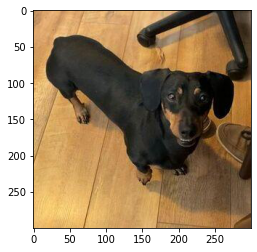

In [4]:
# Loading the image
img_path = 'img/Capi_300.jpg'
#img = cv2.imread(img_path)
#plt.imshow(img)
img=plt.imread('img/Capi_300.jpg')
plt.imshow(img)
plt.show()

Veamos el tamaño de la imagen

In [5]:
img.shape

(300, 300, 3)

### División de la imagen en formato RGB

Sabemos que una imagen digital en color es una combinación de matrices R, G y B (rojo, verde, azul) apiladas unas sobre otras. Es necesario dividir cada canal de la imagen y extraer los componentes principales de cada uno de ellos.

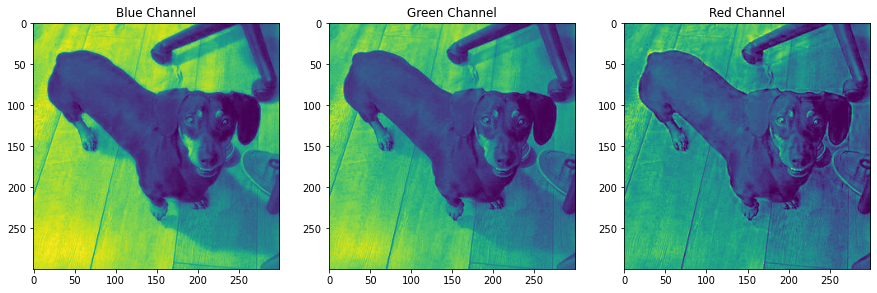

In [6]:
blue,green,red = cv2.split(img)

# Veámoslo en sus diferentes matices
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

Escalamos los datos

In [7]:
df_blue = blue/255
df_green = green/255
df_red = red/255

### PCA con Jacobi

In [8]:
evalues, q_k, pca_k = returnPCA(df_blue,"jacobi")

Sweeps 12
------------------------
Off(x_k) = 4.64434533064189e-08
tolerancia = 1.1291604837680821e-07


La matriz q_k queda como:
[[ 0.002  0.002  0.019 ... -0.085 -0.001 -0.005]
 [ 0.001  0.001  0.015 ...  0.056 -0.036 -0.016]
 [ 0.001  0.002  0.016 ... -0.087  0.067 -0.044]
 ...
 [-0.027  0.004  0.106 ... -0.076 -0.055  0.074]
 [-0.029 -0.001  0.105 ...  0.06  -0.122 -0.09 ]
 [-0.031 -0.003  0.102 ... -0.048  0.114  0.008]]
------------------------




In [9]:
evalues_g, q_k_g, pca_k_g = returnPCA(df_green,"jacobi")

Sweeps 12
------------------------
Off(x_k) = 3.955010252000838e-08
tolerancia = 5.7625781190349237e-08


La matriz q_k queda como:
[[ 0.004 -0.012  0.029 ...  0.031  0.011  0.023]
 [ 0.003 -0.012  0.023 ... -0.008  0.052  0.011]
 [ 0.003 -0.012  0.025 ...  0.041 -0.017 -0.037]
 ...
 [-0.012 -0.001  0.112 ...  0.03  -0.013 -0.09 ]
 [-0.016  0.004  0.111 ...  0.032  0.114  0.006]
 [-0.019  0.007  0.106 ...  0.015 -0.036  0.011]]
------------------------




In [10]:
evalues_r, q_k_r, pca_k_r = returnPCA(df_red,"jacobi")

Sweeps 12
------------------------
Off(x_k) = 1.428643648947928e-08
tolerancia = 1.5953266404799593e-08


La matriz q_k queda como:
[[-0.     0.014 -0.029 ... -0.054 -0.132 -0.008]
 [-0.001  0.015 -0.021 ... -0.055  0.081 -0.004]
 [-0.001  0.016 -0.02  ...  0.108 -0.046  0.01 ]
 ...
 [ 0.028 -0.015 -0.114 ... -0.025 -0.171  0.008]
 [ 0.022 -0.024 -0.111 ...  0.044  0.144  0.037]
 [ 0.016 -0.028 -0.1   ... -0.023 -0.044 -0.013]]
------------------------




### Varianza explicada

In [11]:
total_evalues_b = sum(evalues)
var_exp = [(i/total_evalues_b) for i in sorted(evalues, reverse=True)]

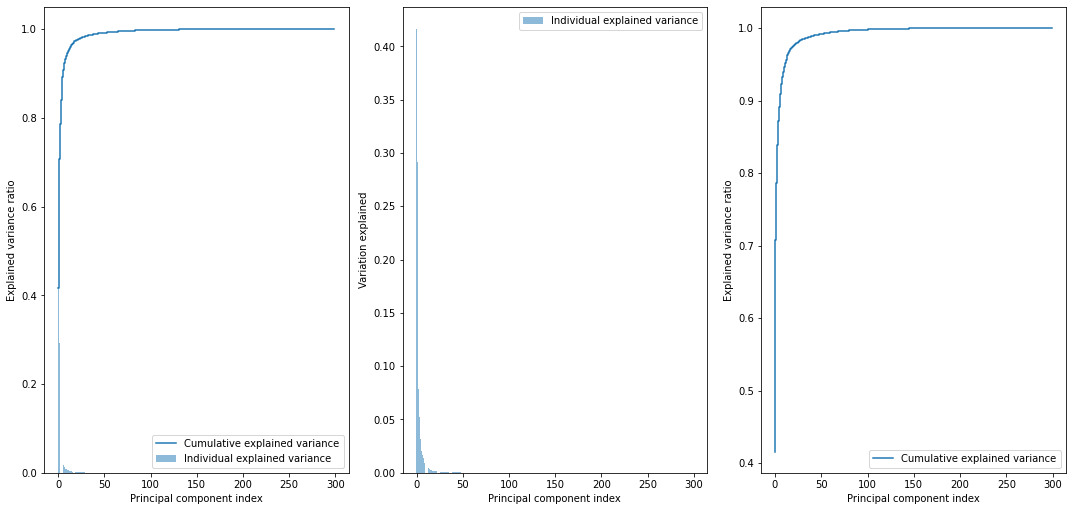

In [12]:
# Plot the explained variance against cumulative explained variance
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

fig.add_subplot(132)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Variation explained')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

fig.add_subplot(133)
#plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Podemos ver que con 50 componentes principales ya se explica más del 95% y con 72 componentes (de 300) se explica el 99%.

In [13]:
#cum_sum_exp

**Canal verde**

In [14]:
total_evalues_g = sum(evalues_g)
var_exp_g = [(i/total_evalues_g) for i in sorted(evalues_g, reverse=True)]

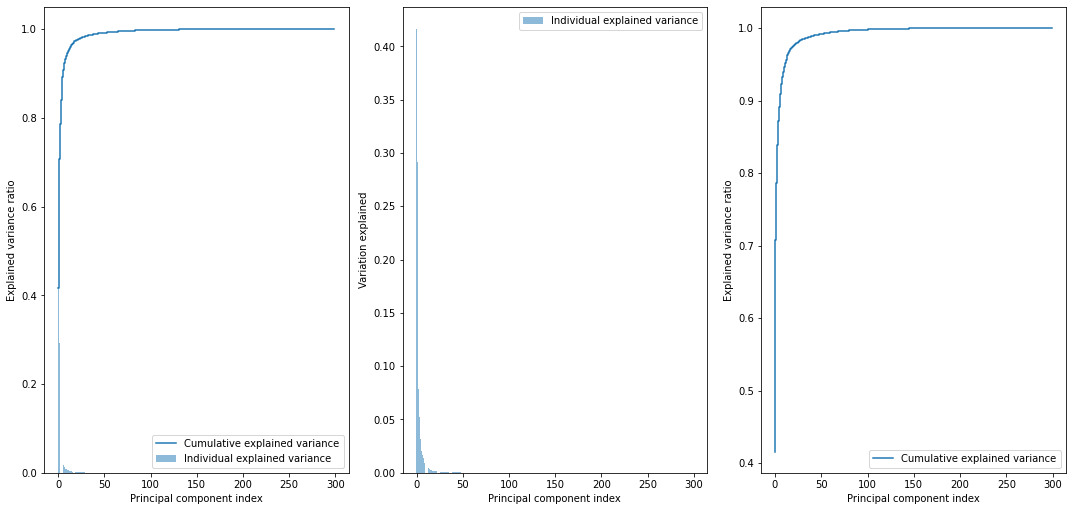

In [15]:
# Plot the explained variance against cumulative explained variance
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

fig.add_subplot(132)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Variation explained')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

fig.add_subplot(133)
#plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [16]:
# Para ver con cuantos componentes se explica
#cum_sum_exp

**Canal rojo**

In [17]:
total_evalues_r = sum(evalues_r)
var_exp_r = [(i/total_evalues_r) for i in sorted(evalues_r, reverse=True)]

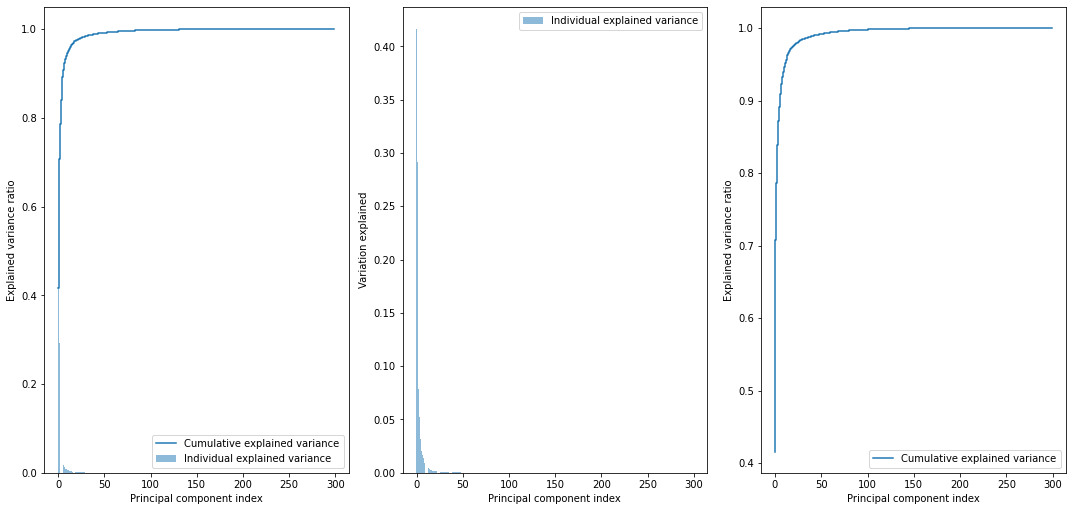

In [18]:
# Plot the explained variance against cumulative explained variance
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

fig.add_subplot(132)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
#plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Variation explained')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

fig.add_subplot(133)
#plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [19]:
# Para ver con cuantos componentes se explica
#cum_sum_exp

En el caso de los tres canales tenemos un desempeño similar, con menos de la cuarta parte de los datos.

### IMPORTANTE: Pendiente inverse_transform

In [21]:
np.set_printoptions(precision=3, suppress=True)

In [22]:
img=plt.imread('img/Capi_300.jpg')

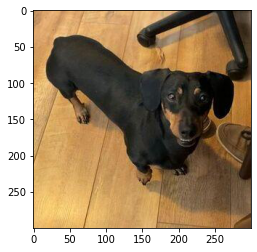

In [23]:
plt.imshow(img)
plt.show()

In [24]:
b = img[:,:,0]
g = img[:,:,1]
r = img[:,:,2]

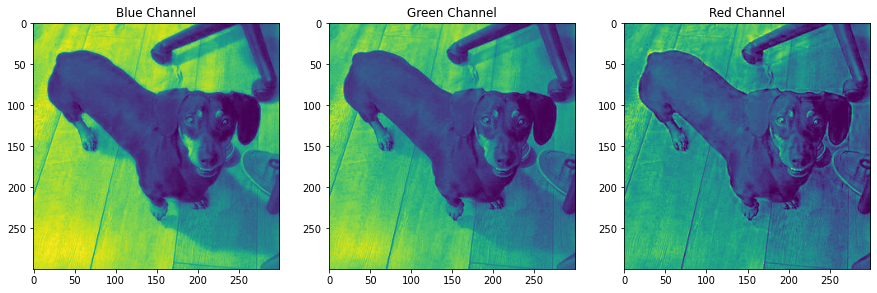

In [25]:
#Splitting into channels
#blue,green,red = cv2.split(img)
# Plotting the images
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(b)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(g)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(r)
plt.show()

In [26]:
df_blue = b/255
df_green = g/255
df_red = r/255

In [27]:
pca_b = PCA(n_components=50)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=50)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=50)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

In [28]:
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

Blue Channel : 0.991735312788283
Green Channel: 0.9846153727870853
Red Channel  : 0.955207320440407


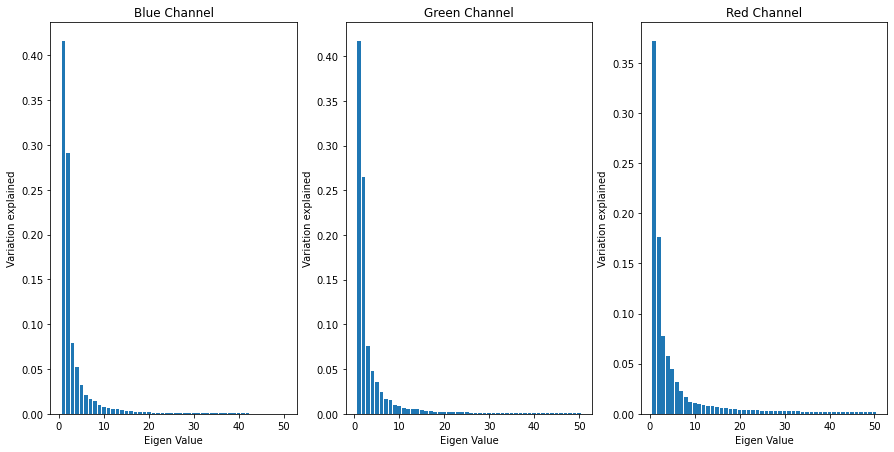

In [29]:
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_b.explained_variance_ratio_)
fig.add_subplot(132)
plt.title("Green Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_g.explained_variance_ratio_)
fig.add_subplot(133)
plt.title("Red Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_r.explained_variance_ratio_)
plt.show()

In [30]:
data_red =  np.dot(df_red - pca_r.mean_, pca_r.components_.T)

In [31]:
dat_inv_trans = np.dot(data_red, pca_r.components_) + pca_r.mean_

In [32]:
pca_r.inverse_transform(trans_pca_r)

array([[0.425, 0.401, 0.383, ..., 0.304, 0.3  , 0.271],
       [0.426, 0.386, 0.361, ..., 0.289, 0.297, 0.267],
       [0.409, 0.379, 0.357, ..., 0.296, 0.303, 0.271],
       ...,
       [0.461, 0.453, 0.441, ..., 0.166, 0.162, 0.158],
       [0.452, 0.445, 0.418, ..., 0.154, 0.16 , 0.151],
       [0.454, 0.434, 0.404, ..., 0.142, 0.161, 0.146]])

### Recontrucción de la imagen

Ahora que tenemos una reducción de dimensionalidad usando nuestra función PCA, sabemos que tenemos un más del 95% de varianza explicada, ahora visualizaremos la imagen nuevamente y para eso, primero tenemos que invertir la transformación de los datos y luego fusionar los datos de los 3 canales en uno.

In [33]:
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
#print(b_arr.shape, g_arr.shape, r_arr.shape)

In [34]:
img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
#print(img_reduced.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


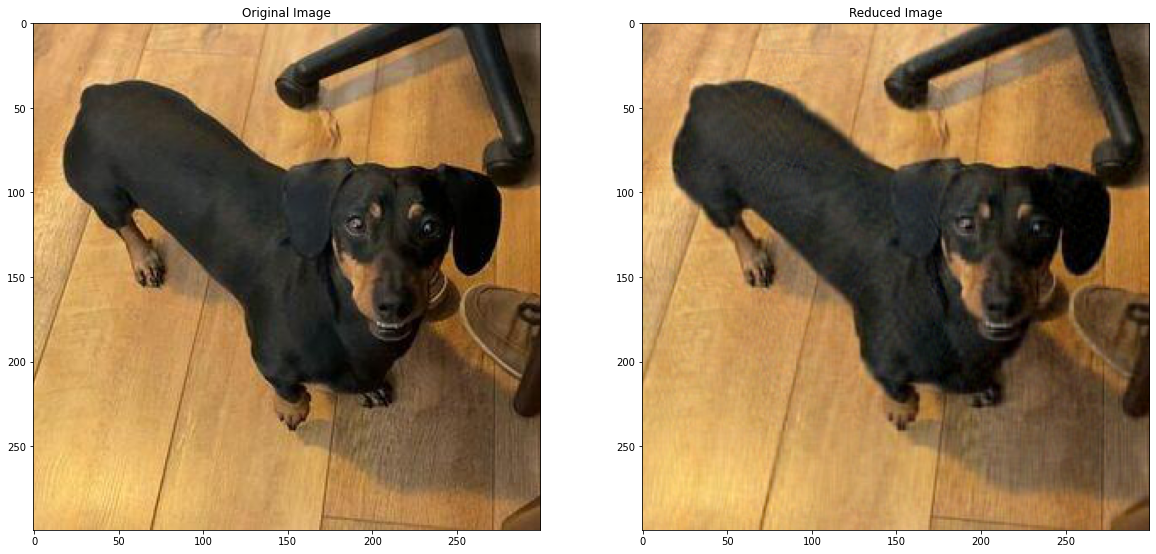

In [35]:
fig = plt.figure(figsize = (20, 10)) 
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(img)
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()

Como nuestro ojo humano puede apreciar, la diferencia entre las dos imágenes es mínima, sin embargo, hemos usado la sexta parte de la información.

## Conclusiones

Como se vio durante el curso y que fue uno de los propósitos a demostrar en este proyecto, el tener demasiadas características de una observación se traduce en demasiadas dimensiones que definen a un objeto o registro y este, a su vez, genera un costo computacional muy alto al querer transformar, manipular o  computar datos para efectos de cualquier estudio o análisis. Sim embargo, la compresión de imágenes con análisis de componentes principales es una aplicación útil y relativamente sencilla de implementar gracias a que podemos ver a las imágenes como matrices hechas de valores del color de los píxeles. Además, tuvimos la oportunidad de extender esta implementación usando las rotaciones de Jacobi para crear nuestra propia función para obtener las PCA y a partir de estas, poder reducir la dimensión de una imagen en color dividiéndola en 3 canales y luego reconstruyéndola para su visualización.

La reducción de la dimensionalidad actualmente es aplicada en distintos campos, por ejemplo: procesamiento de señales de video como remasterización, procesamiento de señales de audio como reducción de ruido, reconocimiento de voz como en las IA Alexa, Siri o Cortana, visualización de grandes volúmenes de datos (Big Data), en modelado de datos para predicción, Machine learning, compresión de imágenes con la menor pérdida de calidad como lo expuesto en este proyecto, etc. En estos casos es posible que nos enfrentaríamos a problemas con la convergencia de los algoritmos que desarrollamos para este trabajo, por lo que esperamos en un futuro mejorar nuestras implementaciones para poder sobrellevar este tipo de retos.

Vimos también que, debido a que los recursos computacionales son finitos, es imperativo optimizar los problemas que ayudan a reducir características mediante la reducción de dimensionalidad. Esto tiene importantes beneficios como optimizar el tiempo y costo computacional en el entrenamiento de modelos; transformar datos no lineales en una forma linealmente separables; facilidad para visualizar, analizar y entender los datos; eliminación de características redundantes en los datos; etc. Nosotros pensamos que, en específico, uno de los grandes beneficios es el tema de la reducción en el espacio de almacenamiento de los datos que pueden generar altos costos, monetarios y ambientales, de almacenaje y manutención de la infraestructura.


## Bibliografía

* [1] [Palacios E. (2021) Libro de Optimización](https://itam-ds.github.io/analisis-numerico-computo-cientifico/2.computo_matricial/2.3/Algoritmos_y_aplicaciones_de_eigenvalores_eigenvectores_de_una_matriz.html) 
* [2] [Golub, G.H., and Van Loan, C.F. (1989) Matrix Computations, 3er ed. (Johns Hopkins University Press).](https://twiki.cern.ch/twiki/pub/Main/AVFedotovHowToRootTDecompQRH/Golub_VanLoan.Matr_comp_3ed.pdf)
* [3] [Alter O, Brown PO, Botstein D. (2000) Singular value decomposition for genome-wide expression data processing and modeling](https://doi.org/10.1073/pnas.97.18.10101)
* [4] [Amat J. (2017) Análisis de Componentes Principales](https://www.cienciadedatos.net/documentos/35_principal_component_analysis)
* [5] [Batal I., Strobl E., Hauskrecht M. (2014) Principal Component Analysis (PCA)and Singular Value Decomposition (SVD)](https://people.cs.pitt.edu/~milos/courses/cs3750-Fall2014/lectures/class9.pdf)
* [6] [Hurtado R. (2021) Compresión de Imágenes Mediante Reducción de Dimensionalidad con Técnica de Análisis de Componentes Principales (PCA)](https://efecode.com/compresion-imagenes-reduccion-dimensionalidad-tecnica-analisis-componentes-principales-pca-visualizacion)
* [7] [Fu D., Guimaraes G. (2016) Using Compression to Speed Up Image Classification in Artificial Neural Networks](https://www.danfu.org/files/CompressionImageClassification.pdf)

## Referencias código

* [1] [How to Calculate Principal Component Analysis (PCA) from Scratch in Python](https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/)
* [2] [numpy.column_stack](https://numpy.org/doc/stable/reference/generated/numpy.column_stack.html#numpy.column_stack)
* [3] [numpy.triu_indices](https://numpy.org/doc/stable/reference/generated/numpy.triu_indices.html)
* [4] [Dimensionality reduction of color image using PCA](https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118)
* [5] [How to reverse PCA and reconstruct original variables from several principal components?](https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com)
* [5] [On the Applications of Robust PCA in Image and Video Processing](https://ieeexplore.ieee.org/document/8425659)
* [6] [Application of Principal Component Analysis to Image Compression](https://www.intechopen.com/chapters/59936)
* [7] [Principal Component Analysis in Image Processing](https://www2.humusoft.cz/www/papers/tcp05/mudrova.pdf)